# **FLIPKART GRID 5.0**
**Problem Statement : Personalized Product Recommendations**

**Team Name: MINIONS**

**Importing required libraries**

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Generating a fake dataset**

In [ ]:
pip install faker

In [ ]:
from faker import Faker
import random
import pandas as pd

# Initialize Faker
fake = Faker()

# Generate user interactions data
num_users = 100
num_products = 50
num_interactions = 1000

user_ids = [fake.uuid4() for _ in range(num_users)]
product_ids = [fake.uuid4() for _ in range(num_products)]

user_interactions = []
for _ in range(num_interactions):
    user_id = random.choice(user_ids)
    product_id = random.choice(product_ids)
    rating = random.randint(1, 5)
    user_interactions.append({'user_id': user_id, 'product_id': product_id, 'rating': rating})

user_interactions_df = pd.DataFrame(user_interactions)

# Generate product details data
product_details = []
for product_id in product_ids:
    name = fake.word()
    category = fake.word()
    price = round(random.uniform(10, 100), 2)
    product_details.append({'product_id': product_id, 'name': name, 'category': category, 'price': price})

product_details_df = pd.DataFrame(product_details)

# Save dataframes to CSV files
user_interactions_df.to_csv('user_interactions.csv', index=False)
product_details_df.to_csv('product_details.csv', index=False)

In [ ]:
import pandas as pd

# Load user interactions data
user_interactions = pd.read_csv('user_interactions.csv')

# Load product details data
product_details = pd.read_csv('product_details.csv')

# Combine user interactions and product details
data = pd.merge(user_interactions, product_details, on='product_id', how='left')


In [ ]:
data.head()

,user_id,product_id,rating,name,category,price
0,ce17bff3-0780-40da-baff-094ed1291a7e,ee867bdf-dbd2-44b7-b956-859f9002bedf,1,real,surface,61.07
1,02cc89db-3656-4b18-ad58-07b6ac82a03e,4de69281-d5b7-4f50-9d80-798b36a24f8f,2,after,strategy,50.52
2,fc44cab5-3755-4d4a-a361-a8e407d424e4,8250bcd5-540a-48af-bd6a-d5b2e75a53f3,1,window,sign,45.46
3,2f29e707-5f2c-483e-90b9-ae23d8e94ec8,8e60cb9d-8c23-4477-a278-efaeba012745,2,real,among,98.97
4,a2be5820-728b-4792-a8c3-87fef0ca841b,4de69281-d5b7-4f50-9d80-798b36a24f8f,4,after,strategy,50.52


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,1000.0,2.88600,1.423738,1.00,2.00,3.00,4.00,5.00
price,1000.0,55.52477,24.280365,14.05,38.69,53.07,74.24,98.97


In [ ]:
# checking null values
data.isna().sum()

user_id       0
product_id    0
rating        0
name          0
category      0
price         0
dtype: int64

In [ ]:
data.dtypes

user_id        object
product_id     object
rating          int64
name           object
category       object
price         float64
dtype: object

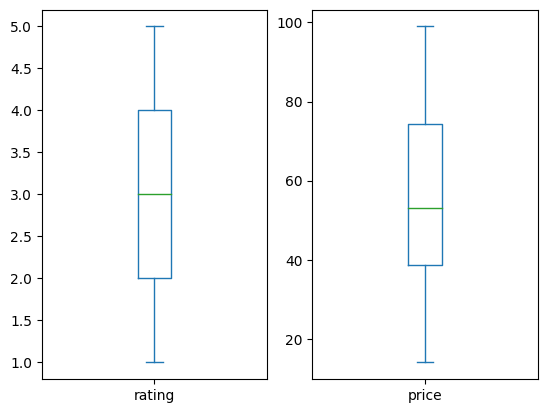

In [ ]:
# box and whisker plots
data.plot(kind="box", subplots=True, sharex=False, sharey=False)
plt.show()

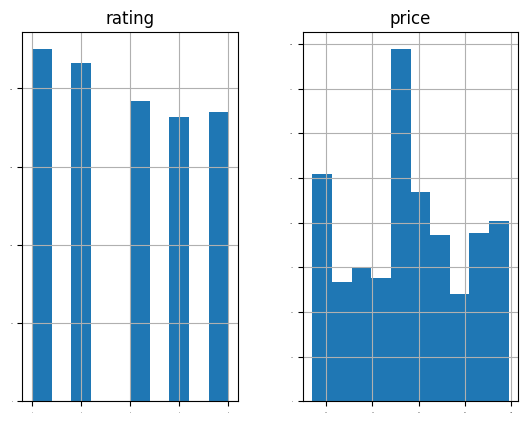

In [ ]:
# histogram
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

<ipython-input-69-bb53c5da8315>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,linewidths=1)


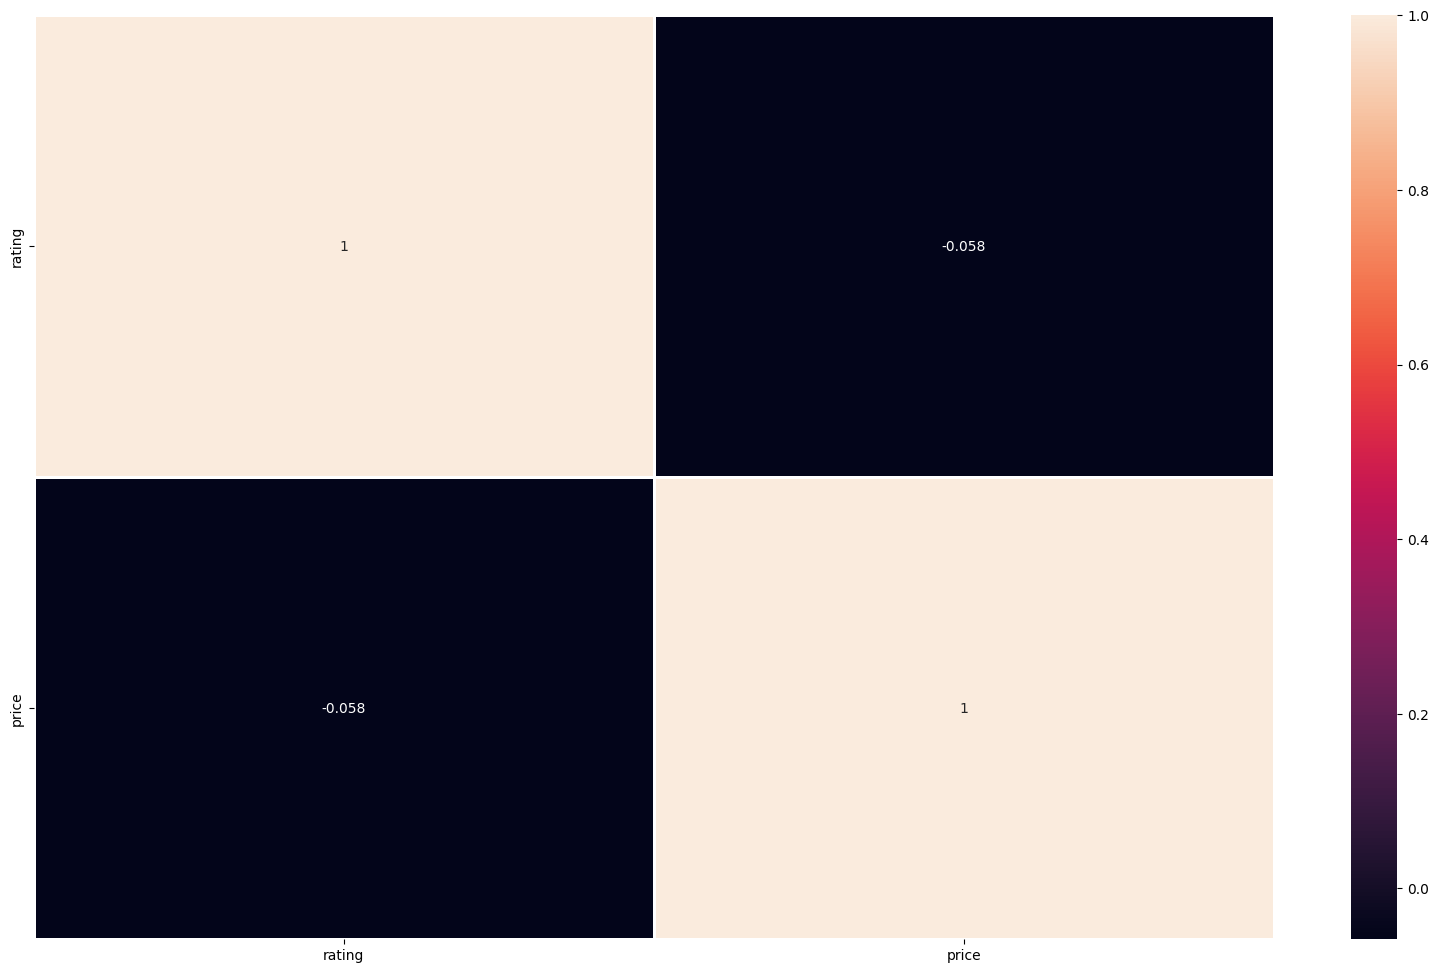

In [ ]:
#correlation between variables with heat map
fig,ax=plt.subplots(1,1,figsize=(20,12))
sns.heatmap(data.corr(),annot=True,linewidths=1)
plt.show()

In [ ]:
#training and testing data
x=data.iloc[:,[0,1,3,4,5]]
y=data.iloc[:,2]

In [ ]:
x

,user_id,product_id,name,category,price
0,ce17bff3-0780-40da-baff-094ed1291a7e,ee867bdf-dbd2-44b7-b956-859f9002bedf,real,surface,61.07
1,02cc89db-3656-4b18-ad58-07b6ac82a03e,4de69281-d5b7-4f50-9d80-798b36a24f8f,after,strategy,50.52
2,fc44cab5-3755-4d4a-a361-a8e407d424e4,8250bcd5-540a-48af-bd6a-d5b2e75a53f3,window,sign,45.46
3,2f29e707-5f2c-483e-90b9-ae23d8e94ec8,8e60cb9d-8c23-4477-a278-efaeba012745,real,among,98.97
4,a2be5820-728b-4792-a8c3-87fef0ca841b,4de69281-d5b7-4f50-9d80-798b36a24f8f,after,strategy,50.52
...,...,...,...,...,...
995,b1859812-ffb3-4ffd-92b9-3b0292b12bc2,b197e561-d74c-408c-99b6-33228449a9ee,nature,phone,38.70
996,254bd512-ce36-4c92-b5c2-2d204c458230,91042b29-1b95-4e5a-92c0-5c0b87174925,they,push,51.38
997,06bddaa3-45b9-49bf-94a0-2e3ff761edd4,526e7762-8744-4fe7-9875-ee1b3ffd7cf6,any,power,96.86
998,59872d13-9c23-4fc1-b518-ea8ec23d1c82,68e3632b-be56-45d8-9ac8-17e21df95ca8,grow,easy,69.00


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame to preserve the original data
X_encoded = x.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ['user_id', 'product_id', 'category', 'name']
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X_encoded[col])

# Now X_encoded contains the encoded values


In [ ]:
X_encoded

,user_id,product_id,name,category,price
0,75,45,27,40,61.07
1,1,12,1,39,50.52
2,97,24,45,37,45.46
3,18,26,27,2,98.97
4,62,12,1,39,50.52
...,...,...,...,...,...
995,66,35,23,28,38.70
996,15,27,41,31,51.38
997,2,15,2,29,96.86
998,34,19,14,14,69.00


In [ ]:
y

0      1
1      2
2      1
3      2
4      4
      ..
995    4
996    3
997    1
998    5
999    3
Name: rating, Length: 1000, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# spot check algorithms
models = []
models.append(("LR", LogisticRegression(solver="lbfgs", max_iter=1000)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("RF", RandomForestRegressor()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC()))

In [ ]:
# evaluate each model in turn
results = []
for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = -scores  # Convert negative MSE scores to positive RMSE scores
    results.append((name, rmse_scores.mean(), rmse_scores.std()))

# Display the results
for name, mean_score, std_score in results:
    print(f'{name}: Mean RMSE = {mean_score:.4f}, Std Dev = {std_score:.4f}')

LR: Mean RMSE = 3.8488, Std Dev = 0.4070
LDA: Mean RMSE = 3.8962, Std Dev = 0.4493
DT: Mean RMSE = 3.8900, Std Dev = 0.2625
RF: Mean RMSE = 2.3629, Std Dev = 0.2124
KNN: Mean RMSE = 4.2275, Std Dev = 0.4249
NB: Mean RMSE = 3.8312, Std Dev = 0.4931
SVM: Mean RMSE = 3.8075, Std Dev = 0.3470


# **RF: Mean RMSE = 2.3629, Std Dev = 0.2124**
(RF - RandomForestRegressor)

---



In [ ]:
pip install surprise

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_user_similarity(data):
    # Load data into Surprise Dataset
    reader = Reader(rating_scale=(1, 5))
    data_surprise = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader)

    # Split data into train and test sets
    trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

    # Initialize and train a collaborative filtering model (e.g., SVD)
    cf_model = SVD(n_factors=50, random_state=42)
    cf_model.fit(trainset)

    # Get user and item factors from the trained model
    user_factors = cf_model.pu
    item_factors = cf_model.qi

    # Calculate user similarity based on cosine similarity of item factors
    user_similarity_matrix = cosine_similarity(item_factors)

    return user_similarity_matrix


In [ ]:
# Feature: User preferences (e.g., ratings, clicks, purchases)
user_preferences = data.groupby('user_id')['rating'].mean()

# Feature: Product popularity (e.g., average ratings, number of interactions)
product_popularity = data.groupby('product_id')['rating'].mean()

# Feature: User similarity (e.g., collaborative filtering, cosine similarity)
# Calculate user similarity using collaborative filtering or other methods
user_similarity_matrix = calculate_user_similarity(data)


In [ ]:
data.head()

,user_id,product_id,rating,name,category,price
0,ce17bff3-0780-40da-baff-094ed1291a7e,ee867bdf-dbd2-44b7-b956-859f9002bedf,1,real,surface,61.07
1,02cc89db-3656-4b18-ad58-07b6ac82a03e,4de69281-d5b7-4f50-9d80-798b36a24f8f,2,after,strategy,50.52
2,fc44cab5-3755-4d4a-a361-a8e407d424e4,8250bcd5-540a-48af-bd6a-d5b2e75a53f3,1,window,sign,45.46
3,2f29e707-5f2c-483e-90b9-ae23d8e94ec8,8e60cb9d-8c23-4477-a278-efaeba012745,2,real,among,98.97
4,a2be5820-728b-4792-a8c3-87fef0ca841b,4de69281-d5b7-4f50-9d80-798b36a24f8f,4,after,strategy,50.52


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Create feature matrix (X) and target variable (y)
X = user_interactions[['user_id', 'product_id']]
X['user_pref'] = X['user_id'].map(user_preferences)
X['product_popularity'] = X['product_id'].map(product_popularity)

# Calculate user similarity averages and store them in a list
user_sim_averages = []
for user_id in X['user_id']:
    user_index = np.where(user_similarity_matrix[:, 0] == user_id)[0]
    if len(user_index) > 0:
        user_sim_averages.append(np.mean(user_similarity_matrix[user_index, 1:]))
    else:
        user_sim_averages.append(0)  # Default value if user similarity info is missing

X['user_similarity'] = user_sim_averages

y = user_interactions['rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model (e.g., Random Forest Regressor)
model = RandomForestRegressor()
model.fit(X_train[['user_pref', 'product_popularity', 'user_similarity']], y_train)

# Make predictions
y_pred = model.predict(X_test[['user_pref', 'product_popularity', 'user_similarity']])

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# In this code, user_similarity_matrix is assumed to be a NumPy array where the first column contains user IDs and the remaining columns contain similarity values. The np.where function is used to find the row index corresponding to the user ID, and then user_similarity_matrix[user_index, 1:] selects the similarity values for that user.

<ipython-input-82-9f69e58ba7bc>:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  user_index = np.where(user_similarity_matrix[:, 0] == user_id)[0]


Mean Squared Error: 2.065735066442744


**recommended products for a specific user**

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load user interactions data and product details data
user_interactions = pd.read_csv('user_interactions.csv')
product_details = pd.read_csv('product_details.csv')

# Calculate user preferences, product popularity, and user similarity
user_preferences = user_interactions.groupby('user_id')['rating'].mean()

# Aggregate duplicate interactions
interaction_matrix = user_interactions.groupby(['user_id', 'product_id'])['rating'].sum().unstack(fill_value=0)

# Calculate user similarity using cosine similarity
user_similarity = cosine_similarity(interaction_matrix)

# Define a target user
target_user_id = 'ce17bff3-0780-40da-baff-094ed1291a7e'  ### include user ID for which, the recommended products should be specified

# Find the index of the target user in the interaction matrix
target_user_index = interaction_matrix.index.get_loc(target_user_id)

# Find indices of nearest neighbors
nearest_neighbors_indices = user_similarity[target_user_index].argsort()[-5:-1]

# Get products interacted by nearest neighbors but not by the target user
target_user_products = interaction_matrix.columns[interaction_matrix.loc[target_user_id] > 0]
similar_products = set()

for neighbor_index in nearest_neighbors_indices:
    neighbor_products = interaction_matrix.columns[interaction_matrix.iloc[neighbor_index] > 0]
    similar_products.update(neighbor_products.difference(target_user_products))

# Rank and recommend similar products
recommended_products = product_details[product_details['product_id'].isin(similar_products)]

print(f"Recommended Products for user {target_user_id}:")
print(recommended_products[['product_id', 'name', 'category', 'price']])


Recommended Products for user ce17bff3-0780-40da-baff-094ed1291a7e:
                              product_id         name   category  price
0   cc0955b9-5d9a-44b5-a6f2-839d46feaf44         time    include  74.24
1   b09a0f23-6325-43e6-8584-13ef60324345       season       line  44.71
2   b8c05c6b-d8ec-4b98-a114-4f409ccb7e29   democratic         my  28.17
5   58508c05-3cba-43bc-b1e4-1398ec2a0bae          cut      catch  48.42
6   2007c302-c911-4877-b8c7-13d77fcb6e59        their        key  56.94
7   7b38e2f9-feb6-4229-ab17-29e649a37a38          you       with  53.07
11  5dd20ef1-3ba4-48c1-9bb4-1316e1d3da98        adult         TV  45.02
15  85f211c2-f7de-40ef-ac2b-4b61cfef6462     research      level  50.23
16  b1f290a4-6313-4cd9-a2a7-f00e95297696          buy      south  31.70
17  cf1adce6-3929-480a-a2b6-0a0f5e612d53     personal       what  50.33
25  15ab9bd9-7d19-4443-a066-ad9a4b46a644        throw   approach  16.58
27  8e60cb9d-8c23-4477-a278-efaeba012745         real      among  98